In [1]:
# Import & Read Data
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark

from pyspark.sql import *
spark = SparkSession.builder.appName('bank-full').getOrCreate()
from pyspark.ml.classification import LogisticRegression

df = spark.read.csv('Datasets/bank-additional-full.csv',header = True, inferSchema = True)

#Print Schema
df.printSchema()
print(df.columns)
print(df.head(1))

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcom

In [2]:
from pyspark.sql.functions import format_number, col
df.groupby('poutcome','y').count().collect()

[Row(poutcome='nonexistent', y='yes', count=3141),
 Row(poutcome='nonexistent', y='no', count=32422),
 Row(poutcome='failure', y='no', count=3647),
 Row(poutcome='success', y='no', count=479),
 Row(poutcome='failure', y='yes', count=605),
 Row(poutcome='success', y='yes', count=894)]

In [3]:
df.groupby('y').count().collect()

[Row(y='no', count=36548), Row(y='yes', count=4640)]

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  import sys


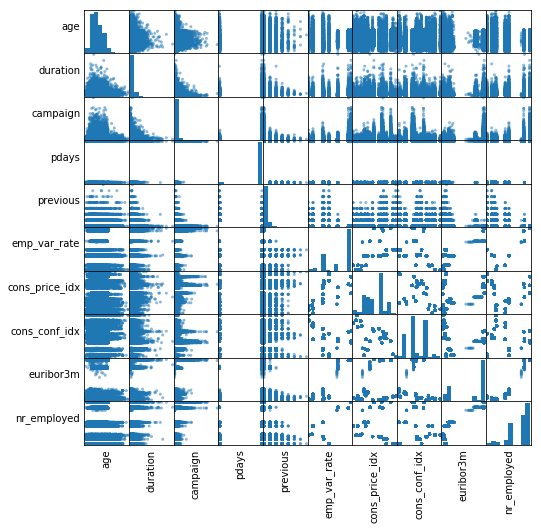

In [28]:
import pandas as pd
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
df.select(numeric_features).describe().toPandas().transpose()
import matplotlib.pyplot as plt
import numpy as np
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [5]:
#Checking Missing columns
print('Total Coloums:',df.count())
dropped_df = df.na.drop()
print("Missing Coloums:",df.count()- dropped_df.count())
missing_field_df = df.na.drop(subset="marital")
print("Missing Coloums(Marital):",df.count() - missing_field_df.count())
missing_field_df = df.na.drop(subset="job")
print("Missing Coloums(Job):",df.count() - missing_field_df.count())
missing_field_df = df.na.drop(subset="education")
print("Missing Coloums(Education):",df.count() - missing_field_df.count())
missing_field_df = df.na.drop(subset="default")
print("Missing Coloums(Default):",df.count() - missing_field_df.count())
missing_field_df = df.na.drop(subset="housing")
print("Missing Coloums(housing):",df.count() - missing_field_df.count())
missing_field_df = df.na.drop(subset="loan")
print("Missing Coloums(Loan):",df.count() - missing_field_df.count())

Total Coloums: 41188
Missing Coloums: 10700
Missing Coloums(Marital): 80
Missing Coloums(Job): 330
Missing Coloums(Education): 1731
Missing Coloums(Default): 8597
Missing Coloums(housing): 990
Missing Coloums(Loan): 990


In [6]:
#Fill in & drop missing columns
#df.groupBy('default').mean().show()
#df.groupBy('marital').mean().show()
filled_df = df.na.fill('unknown',subset = ['default'])
filled_df = filled_df.na.fill('unknown',subset = ['marital'])
filled_df = filled_df.na.drop(subset = 'job')
filled_df = filled_df.na.drop(subset = 'Education')
filled_df = filled_df.na.drop(subset = 'housing')
filled_df = filled_df.na.drop(subset = 'Loan')
filled_df.count()

38311

In [7]:
filled_df = filled_df.select('age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y')
filled_df.printSchema()
print(filled_df.head(1))
filled_df.groupBy('default').mean().show()
filled_df.groupBy('marital').mean().show()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = true)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)

[Row(age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', duration=261, campaign=1, pdays=999, previous=0, poutcome='nonexistent', emp_var_rate=1.1, cons_price_id

In [8]:
import pandas as pd
pd.DataFrame(filled_df.take(20), columns = filled_df.columns)

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,24,technician,single,professional.course,no,yes,no,telephone,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,25,services,single,high.school,no,yes,no,telephone,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,222,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,OneHotEncoder,StringIndexer)

job_indexer = StringIndexer(inputCol='job',outputCol='jobIndex')
marital_indexer = StringIndexer(inputCol='marital',outputCol='maritalIndex')
education_indexer = StringIndexer(inputCol='education',outputCol='educationIndex')
default_indexer = StringIndexer(inputCol='default',outputCol='defaultIndex')
housing_indexer = StringIndexer(inputCol='housing',outputCol='housingIndex')
loan_indexer = StringIndexer(inputCol='loan',outputCol='loanIndex')
contact_indexer = StringIndexer(inputCol='contact',outputCol='contactIndex')
poutcome_indexer = StringIndexer(inputCol='poutcome',outputCol='poutcomeIndex')
y_indexer = StringIndexer(inputCol='y',outputCol='label')

job_encoder = OneHotEncoder(inputCol='jobIndex',outputCol='jobVec')
marital_encoder = OneHotEncoder(inputCol='maritalIndex',outputCol='maritalVec')
education_encoder = OneHotEncoder(inputCol='educationIndex',outputCol='educationVec')
default_encoder = OneHotEncoder(inputCol='defaultIndex',outputCol='defaultVec')
housing_encoder = OneHotEncoder(inputCol='housingIndex',outputCol='housingVec')
loan_encoder = OneHotEncoder(inputCol='loanIndex',outputCol='loanVec')
contact_encoder = OneHotEncoder(inputCol='contactIndex',outputCol='contactVec')
poutcome_encoder = OneHotEncoder(inputCol='poutcomeIndex',outputCol='poutcomeVec')


assembler = VectorAssembler(inputCols = ['jobVec','maritalVec','educationVec','housingVec','defaultVec',
                                         'loanVec','contactVec','poutcomeVec',
                                         'age','duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
                                         'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],outputCol="features")


In [10]:
default_indexer.fit(filled_df).transform(filled_df)

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: string, defaultIndex: double]

In [11]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[job_indexer, marital_indexer, education_indexer,housing_indexer,default_indexer,
                            loan_indexer, contact_indexer,poutcome_indexer,y_indexer,
                            job_encoder, marital_encoder, education_encoder, 
                            housing_encoder,default_encoder, loan_encoder, contact_encoder,
                            poutcome_encoder, assembler])

pipeline_model = pipeline.fit(filled_df)
pipe_df = pipeline_model.transform(filled_df)
#pipe_df = pipe_df.select('label', 'features')
selectCols = ['label','features'] + filled_df.columns
pipe_df = pipe_df.select(selectCols)
pipe_df.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = true)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [12]:
# Using a for loop to find all columns that belong to the numeric data type. 
numeric_features = [t[0] for t in pipe_df.dtypes if t[1] == 'int' or t[1] == 'double']

# Selecting the numeric features, generating summary statistics, and converting to a Pandas DataFrame.
pipe_df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
label,38311,0.11137793323066482,0.31460367558872837,0.0,1.0
age,38311,39.860640547101355,10.290673589753675,17,98
duration,38311,258.3020542402965,259.86380780487184,0,4918
campaign,38311,2.5673566338649474,2.769590697908604,1,43
pdays,38311,963.4634961238287,184.46474655746354,0,999
previous,38311,0.17029051708386625,0.48740397836330407,0,7
emp_var_rate,38311,0.08194252303578228,1.5662470864202918,-3.4,1.4
cons_price_idx,38311,93.56998201564812,0.5764907220982874,92.201,94.767
cons_conf_idx,38311,-40.541502440542224,4.624496448335341,-50.8,-26.9


In [13]:
# Using a for loop to find all columns that belong to the string data type. 
catgorical_features = [t[0] for t in pipe_df.dtypes]

# Selecting the numeric features, generating summary statistics, and converting to a Pandas DataFrame.
pipe_df.select(catgorical_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
label,38311,0.11137793323066482,0.31460367558872837,0.0,1.0
age,38311,39.860640547101355,10.290673589753675,17,98
job,38311,None,None,admin.,unemployed
marital,38311,None,None,divorced,unknown
education,38311,None,None,basic.4y,university.degree
default,38311,None,None,no,yes
housing,38311,None,None,no,yes
loan,38311,None,None,no,yes
contact,38311,None,None,cellular,telephone


In [14]:
# Using a for loop to find all columns that belong to the string data type. 
catgorical_features = [t[0] for t in pipe_df.dtypes if t[1] == 'string']

# Selecting the numeric features, generating summary statistics, and converting to a Pandas DataFrame.
pipe_df.select(catgorical_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
job,38311,None,None,admin.,unemployed
marital,38311,None,None,divorced,unknown
education,38311,None,None,basic.4y,university.degree
default,38311,None,None,no,yes
housing,38311,None,None,no,yes
loan,38311,None,None,no,yes
contact,38311,None,None,cellular,telephone
poutcome,38311,None,None,failure,success
y,38311,None,None,no,yes


### Data Split

In [15]:
train_data,test_data = pipe_df.randomSplit([0.9,0.1])
print("Training dataset count: " + str(train_data.count()))
print("Test dataset count: " + str(test_data.count()))

Training dataset count: 34422
Test dataset count: 3889


### Logistic Regression

In [16]:
from pyspark.ml.classification import LogisticRegression

lr_model = LogisticRegression(featuresCol='features', labelCol='label')

lr_model = lr_model.fit(train_data)

result = lr_model.transform(test_data)

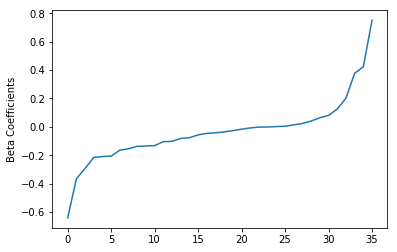

In [17]:
beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

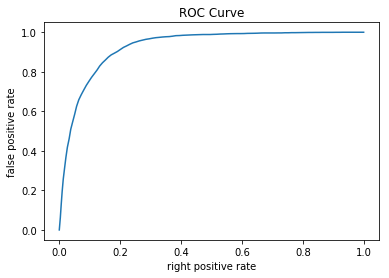

[Logistic Regression]Area Under the Curve:0.9268219822845608


In [18]:
trainingSummary = lr_model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('false positive rate')
plt.xlabel('right positive rate')
plt.title('ROC Curve')
plt.show()

print('[Logistic Regression]Area Under the Curve:' + str(trainingSummary.areaUnderROC))

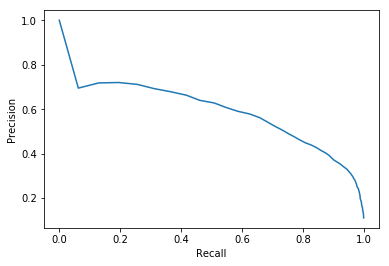

In [19]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [20]:
predictions = lr_model.transform(test_data)
test_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = true)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [21]:
predictions.select('age','job','label','rawPrediction','prediction','probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator =  BinaryClassificationEvaluator()
print('[Logistic Regression]Area Under the Curve', evaluator.evaluate(predictions))
predictions.describe('label','prediction').show()

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 28|admin.|  0.0|[2.55783467553725...|       0.0|[0.92809809513524...|
| 28|admin.|  0.0|[2.14356802807680...|       0.0|[0.89506620199024...|
| 29|admin.|  0.0|[4.03256973713799...|       0.0|[0.98258011884314...|
| 29|admin.|  0.0|[3.77744018438397...|       0.0|[0.97763064917934...|
| 29|admin.|  0.0|[2.10796696973962...|       0.0|[0.89167511793263...|
| 30|admin.|  0.0|[1.24290230236073...|       0.0|[0.77606879793778...|
| 30|admin.|  0.0|[2.68431374904713...|       0.0|[0.93609466425757...|
| 31|admin.|  0.0|[3.77212750892870...|       0.0|[0.97751417118802...|
| 31|admin.|  0.0|[3.11198881214277...|       0.0|[0.95738457188277...|
| 32|admin.|  0.0|[4.35591494762664...|       0.0|[0.98733184641400...|
+---+------+-----+--------------------+----------+--------------

### Decision Tree

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data)

In [23]:
predictions.select('age','job','label','rawPrediction','prediction','probability').show(10)
evaluator =  BinaryClassificationEvaluator()
print('[Decision Tree] Area Under the Curve', evaluator.evaluate(predictions))

+---+------+-----+---------------+----------+--------------------+
|age|   job|label|  rawPrediction|prediction|         probability|
+---+------+-----+---------------+----------+--------------------+
| 28|admin.|  0.0| [1699.0,362.0]|       0.0|[0.82435710819990...|
| 28|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
| 29|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
| 29|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
| 29|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
| 30|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
| 30|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
| 31|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
| 31|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
| 32|admin.|  0.0|[24988.0,413.0]|       0.0|[0.98374079760639...|
+---+------+-----+---------------+----------+--------------------+
only showing top 10 rows

[Decision Tree] Area Under the Curve

### Random Forest Classifier

In [24]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 12)
rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)
#predictions.show(4)

In [25]:
predictions.select('age','job','label','rawPrediction','prediction','probability').show(10)
evaluator =  BinaryClassificationEvaluator()
print('[Random Forest]Area Under the Curve', evaluator.evaluate(predictions))

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 28|admin.|  0.0|[15.6187739475064...|       0.0|[0.78093869737532...|
| 28|admin.|  0.0|[16.2559125562195...|       0.0|[0.81279562781097...|
| 29|admin.|  0.0|[19.8059359395370...|       0.0|[0.99029679697685...|
| 29|admin.|  0.0|[19.8135717103749...|       0.0|[0.99067858551874...|
| 29|admin.|  0.0|[19.2202595449741...|       0.0|[0.96101297724870...|
| 30|admin.|  0.0|[18.6539556624913...|       0.0|[0.93269778312456...|
| 30|admin.|  0.0|[19.2665055583722...|       0.0|[0.96332527791861...|
| 31|admin.|  0.0|[19.7424529201845...|       0.0|[0.98712264600922...|
| 31|admin.|  0.0|[19.7655031716136...|       0.0|[0.98827515858068...|
| 32|admin.|  0.0|[19.8631221100101...|       0.0|[0.99315610550050...|
+---+------+-----+--------------------+----------+--------------

### Gradient-Boosted Tree Classifier

In [26]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label',maxIter = 10)
gbtModel = gbt.fit(train_data)
predictions = gbtModel.transform(test_data)

In [27]:
predictions.select("prediction", "label", "features").show(10)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
Mevaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = Mevaluator.evaluate(predictions)
print('[Gradient-Boosted Tree Classifier]Area Under the Curve: ' + str(accuracy))

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
|       0.0|  0.0|(36,[0,10,13,19,2...|
+----------+-----+--------------------+
only showing top 10 rows

[Gradient-Boosted Tree Classifier]Area Under the Curve: 0.9166880946258679
